对应`tf.kears` 版本的03，在训练过程中加入更多的控制

1. 训练中保存/保存最好的模型
2. 早停 
3. 训练过程可视化

<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow
```

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)  #设备是cuda:0，即GPU，如果没有GPU则是cpu


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 数据准备

In [26]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [27]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [28]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [29]:
# 查看数据
for datas, labels in train_loader:
    print(datas.shape)
    print(labels.shape)
    break
#查看val_loader
for datas, labels in val_loader:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32])


## 定义模型

In [30]:
# 定义一个简单的神经网络类
class NeuralNetwork(nn.Module):
    # __init__ 是类的构造方法，初始化神经网络
    def __init__(self):
        super().__init__()  # 调用父类 nn.Module 的构造方法，初始化 nn.Module 基类
        self.flatten = nn.Flatten()  # 定义一个 Flatten 层，将输入的二维图像（28x28）展平为一维向量
        
        # 定义一个线性层加 ReLU 激活函数的序列
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300),  # 第一层线性变换，将 28*28 的图像展平为 784 维，映射到 300 维
            nn.ReLU(),  # 激活函数 ReLU，增加非线性
            nn.Linear(300, 100),  # 第二层线性变换，将 300 维映射到 100 维
            nn.ReLU(),  # 激活函数 ReLU，增加非线性
            nn.Linear(100, 10),  # 输出层，将 100 维映射到 10 维，对应 10 个类别
        )

    # forward 方法定义了神经网络的前向传播过程
    def forward(self, x):
        # x.shape 是 [batch size, 1, 28, 28]，表示一个批次的图像数据，尺寸为 28x28 的单通道图像
        x = self.flatten(x)  # 使用 Flatten 层将输入的图像展平为一个一维向量
        # 展平后 x.shape 是 [batch size, 28 * 28]，即将每张 28x28 的图像展平为一个 784 维的向量
        logits = self.linear_relu_stack(x)  # 将展平后的输入通过线性层加激活函数序列
        # logits.shape 是 [batch size, 10]，即每个样本经过神经网络的输出为 10 个类别的得分（logits）
        return logits  # 返回网络输出的 logits（即 10 个类别的分数）

# 创建神经网络模型的实例
model = NeuralNetwork()


## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [31]:
from sklearn.metrics import accuracy_score

@torch.no_grad()  # 装饰器，表示在此函数内不需要计算梯度，节省内存并加速计算
def evaluating(model, dataloader, loss_fct):
    loss_list = []   # 用于存储每个batch的损失
    pred_list = []   # 用于存储每个batch的预测结果
    label_list = []  # 用于存储每个batch的真实标签
    
    # 遍历数据加载器中的所有批次
    for datas, labels in dataloader:
        # datas.shape [batch size, 1, 28, 28] - 输入图像，28x28像素，1通道（灰度图像）
        # labels.shape [batch size] - 每个样本的标签
        
        # 将数据和标签转移到指定设备（GPU或CPU）
        datas = datas.to(device)
        labels = labels.to(device)

        # 前向计算：通过模型计算 logits（原始输出值）
        logits = model(datas)  
        
        # 计算损失，损失函数使用的是给定的 `loss_fct`（如交叉熵损失）
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())  # 将当前批次的损失值添加到损失列表中（`loss.item()` 获取损失的数值）

        # 对于分类任务，使用 argmax 找到每个样本在 logits 中的最大值索引
        preds = logits.argmax(axis=-1)  # 对最后一个维度进行 argmax，获取每个样本的预测类别
        # logits.shape 是 [batch_size, num_classes]，通过 axis=-1，`argmax` 会选择每行最大值的索引，即选择概率最大的类别
        
        # 将预测结果（tensor）转换为 CPU 上的 numpy 数组，再转换为 Python 列表，并将其添加到 pred_list 中
        pred_list.extend(preds.cpu().numpy().tolist()) 

        # 同样地，将真实标签（tensor）转换为 CPU 上的 numpy 数组，再转换为 Python 列表，并添加到 label_list 中
        label_list.extend(labels.cpu().numpy().tolist())

    # 使用 sklearn 的 accuracy_score 函数来计算准确率，比较真实标签与预测标签
    acc = accuracy_score(label_list, pred_list)  # 验证集准确率
    
    # 返回验证集的平均损失和准确率
    return np.mean(loss_list), acc


# TensorBoard 可视化

pip install tensorboard
训练过程中可以使用如下命令启动tensorboard服务。注意使用绝对路径，否则会报错

```shell
 tensorboard  --logdir="D:\BaiduSyncdisk\pytorch\chapter_2_torch\runs" --host 0.0.0.0 --port 8848
```

在命令行where tensorboard才可以用

In [32]:
from torch.utils.tensorboard import SummaryWriter

class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        构造函数，初始化 TensorBoardCallback 实例，设置日志目录和数据刷新间隔。
        
        Args:
            log_dir (str): TensorBoard 日志文件存储的目录。
            flush_secs (int, optional): 每隔多少秒将数据刷新到磁盘，默认为 10 秒。
        """
        # 实例化 SummaryWriter，负责向指定的 log_dir 写入日志。flush_secs 控制日志数据刷新到磁盘的间隔
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        """
        绘制模型结构图。
        
        Args:
            model (torch.nn.Module): 要可视化的模型。
            input_shape (tuple): 模型输入数据的形状，用于生成示例输入。
        """
        # 使用 SummaryWriter 的 add_graph 方法画出模型的计算图
        # `torch.randn(input_shape)` 创建一个与输入形状相同的随机输入张量来传递给模型
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        """
        记录训练和验证的损失，并绘制损失曲线。
        
        Args:
            step (int): 当前训练步数。
            loss (float): 当前训练集的损失。
            val_loss (float): 当前验证集的损失。
        """
        # 使用 add_scalars 方法绘制损失曲线。主 tag 为 "training/loss"，
        # 包含两个子 tag："loss" 和 "val_loss"，分别表示训练损失和验证损失。
        # `global_step` 为训练步数，用于表示 x 轴的刻度。
        self.writer.add_scalars(
            main_tag="training/loss",  # 主 tag，表示训练损失
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},  # 子 tag，包含训练和验证的损失
            global_step=step,  # 当前步数，用作 x 轴刻度
        )

    def add_acc_scalars(self, step, acc, val_acc):
        """
        记录训练和验证的准确率，并绘制准确率曲线。
        
        Args:
            step (int): 当前训练步数。
            acc (float): 当前训练集的准确率。
            val_acc (float): 当前验证集的准确率。
        """
        # 使用 add_scalars 方法绘制准确率曲线。主 tag 为 "training/accuracy"，
        # 包含两个子 tag："accuracy" 和 "val_accuracy"，分别表示训练准确率和验证准确率。
        # `global_step` 为训练步数，用于表示 x 轴的刻度。
        self.writer.add_scalars(
            main_tag="training/accuracy",  # 主 tag，表示训练准确率
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},  # 子 tag，包含训练和验证准确率
            global_step=step,  # 当前步数，用作 x 轴刻度
        )

    def add_lr_scalars(self, step, learning_rate):
        """
        记录训练过程中的学习率，并绘制学习率曲线。
        
        Args:
            step (int): 当前训练步数。
            learning_rate (float): 当前学习率。
        """
        # 使用 add_scalars 方法绘制学习率曲线。主 tag 为 "training/learning_rate"，
        # 包含一个子 tag："learning_rate"，表示学习率。
        # `global_step` 为训练步数，用于表示 x 轴的刻度。
        self.writer.add_scalars(
            main_tag="training/learning_rate",  # 主 tag，表示学习率
            tag_scalar_dict={"learning_rate": learning_rate},  # 子 tag，表示学习率
            global_step=step,  # 当前步数，用作 x 轴刻度
        )

    def __call__(self, step, **kwargs):
        """
        允许将 TensorBoardCallback 类实例当作函数来调用，简化训练过程中的日志记录。
        
        Args:
            step (int): 当前训练步数。
            kwargs (dict): 可变的关键字参数，可以包括 loss、val_loss、acc、val_acc、lr 等。
        """
        # 从 kwargs 中获取 loss 和 val_loss 并绘制损失曲线
        loss = kwargs.pop("loss", None)  # 获取训练损失
        val_loss = kwargs.pop("val_loss", None)  # 获取验证损失
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)  # 画损失曲线

        # 从 kwargs 中获取 acc 和 val_acc 并绘制准确率曲线
        acc = kwargs.pop("acc", None)  # 获取训练准确率
        val_acc = kwargs.pop("val_acc", None)  # 获取验证准确率
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)  # 画准确率曲线

        # 从 kwargs 中获取学习率并绘制学习率曲线
        learning_rate = kwargs.pop("lr", None)  # 获取学习率
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)  # 画学习率曲线


### Save Best

In [33]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=500, save_best_only=True):
        """
        在训练过程中定期保存模型的检查点。

        这个实现中，每隔 `save_step` 步保存一次模型。通常情况下，训练脚本会根据评估指标保存模型的最佳状态，但我们这里只在每个 epoch 或每隔若干步时保存模型。

        Args:
            save_dir (str): 保存检查点的目录路径。
            save_step (int, optional): 每隔多少步保存一次模型，默认为 500。
            save_best_only (bool, optional): 是否只保存最好的模型。如果为 `True`，只会保存具有最佳评估指标的模型；否则，会保存每个保存步的模型，默认为 `True`。
        """
        self.save_dir = save_dir  # 保存模型检查点的目录
        self.save_step = save_step  # 每隔多少步保存一次模型
        self.save_best_only = save_best_only  # 是否只保存最好的模型
        self.best_metrics = -1  # 用于保存最佳模型时的评估指标，初始化为 -1，假设所有评估指标均为非负值
        
        # 创建保存模型的目录，如果目录不存在
        if not os.path.exists(self.save_dir):  # 如果保存路径不存在
            os.mkdir(self.save_dir)  # 创建该目录
    
    def __call__(self, step, state_dict, metric=None):
        """
        在每个 `step` 后检查是否需要保存模型的检查点。

        Args:
            step (int): 当前训练步骤。
            state_dict (dict): 模型的状态字典，包含模型的参数。
            metric (float, optional): 当前步骤的评估指标（如准确率、损失等）。仅在 `save_best_only` 为 `True` 时使用。
        """
        if step % self.save_step > 0:  # 如果当前步骤不是保存步数的倍数，则跳过
            return  # 不保存模型，直接返回
        
        if self.save_best_only:  # 如果只保存最好的模型
            assert metric is not None  # 如果启用了保存最佳模型，必须传入评估指标（metric）
            
            # 如果当前的评估指标比之前的最佳指标更好，保存模型
            if metric >= self.best_metrics:
                # 保存最好的模型检查点，覆盖之前保存的文件，文件名为 "best.ckpt"
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # 更新最佳指标
                self.best_metrics = metric
        else:  # 否则保存每个 `step` 的模型
            # 保存当前 `step` 对应的模型检查点，文件名为 `step.ckpt`
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))


### Early Stop

In [34]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """
        早停回调，训练过程中监控模型性能，如果在若干步内没有显著提升则停止训练。
        
        Args:
            patience (int, optional): 如果在 `patience` 个训练步骤内性能没有改善，则停止训练。默认为 5。
            min_delta (float, optional): 最小的性能提升幅度。只有当指标的变化大于 `min_delta` 时，才算作改善。如果性能提升小于这个值，则认为没有改善。默认为 0.01。
        """
        self.patience = patience  # 设定允许多少个步骤没有改进
        self.min_delta = min_delta  # 设定最小的提升幅度，用来判断是否有改进
        self.best_metric = -1  # 记录最好的性能指标，初始化为 -1，假设指标不会为负数
        self.counter = 0  # 计数器，用来跟踪没有改进的训练步骤数

    def __call__(self, metric):
        """
        每个训练步骤调用一次，检查模型的评估指标是否有所提升。

        Args:
            metric (float): 当前训练步骤的评估指标（如准确率、验证集损失等）。
        """
        if metric >= self.best_metric + self.min_delta:  # 如果当前指标有提升（大于最佳指标 + 最小变化阈值）
            # 更新最佳指标
            self.best_metric = metric
            # 重置计数器，因为有了改善
            self.counter = 0
        else:  # 如果当前指标没有提升
            # 计数器加1，记录没有提升的步骤
            self.counter += 1

    @property  # 使用 @property 装饰器，使得 early_stop 可以像属性一样被访问，而无需调用方法（即不用 `()`）
    def early_stop(self):
        """
        返回是否满足停止训练的条件，即如果没有改善超过 `patience` 步，则返回 True。
        """
        return self.counter >= self.patience  # 如果计数器达到 `patience` 值，则说明没有提升，应该停止训练


In [35]:
500*32*5

80000

In [36]:
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    # 用来存储训练和验证过程中的数据记录
    record_dict = {
        "train": [],  # 存储训练数据（loss, acc, step）
        "val": []  # 存储验证数据（loss, acc, step）
    }
    
    global_step = 0  # 全局步数，表示训练了多少步
    model.train()  # 切换到训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:  # 使用tqdm显示训练进度条
        for epoch_id in range(epoch):  # 遍历每一个epoch
            # training
            for datas, labels in train_loader:  # 从train_loader中批量获取训练数据和标签
                datas = datas.to(device)  # 将数据移动到device上（GPU或CPU）
                labels = labels.to(device)  # 将标签移动到device上

                # 梯度清空，避免累积上一次梯度
                optimizer.zero_grad()

                # 模型前向计算，得到预测值logits
                logits = model(datas)
                
                # 计算损失（使用指定的损失函数）
                loss = loss_fct(logits, labels)
                
                # 进行反向传播，计算梯度
                loss.backward()
                
                # 更新模型参数，优化器会根据梯度调整模型权重
                optimizer.step()

                # 使用argmax获取预测值的类别（取最大值的索引）
                preds = logits.argmax(axis=-1)
            
                # 计算训练准确率（将预测值与真实标签比较）
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()  # 获取损失的数值

                # 记录训练数据（loss, acc, step）
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # 每隔eval_step步进行一次验证（eval_step默认值为500）
                if global_step % eval_step == 0:
                    model.eval()  # 切换到验证模式，模型不会更新参数，只会计算验证集的性能
                    # 调用评估函数计算验证集损失和准确率
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    # 记录验证集的数据
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()  # 切换回训练模式

                    # 1. 使用tensorboard可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,  # 记录训练和验证集的loss
                            acc=acc, val_acc=val_acc,  # 记录训练和验证集的准确率
                            lr=optimizer.param_groups[0]["lr"],  # 获取当前学习率
                        )

                    # 2. 保存模型检查点（模型权重）
                    if save_ckpt_callback is not None:
                        # 使用验证集准确率作为metric来判断是否保存最好的模型
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停检查
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)  # 调用早停回调检查验证集准确率
                        if early_stop_callback.early_stop:  # 如果准确率没有提升，则停止训练
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict  # 训练停止，返回记录的数据

                # 更新全局步数
                global_step += 1
                # 更新进度条
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})  # 在进度条上显示当前epoch信息
        
    return record_dict  # 返回记录的训练和验证过程数据


In [37]:
epoch = 100  # 设置训练的总轮数为100轮

# 初始化模型
model = NeuralNetwork()  # 实例化一个NeuralNetwork类对象，NeuralNetwork是自定义的神经网络类

# 1. 定义损失函数，采用交叉熵损失（CrossEntropyLoss）
loss_fct = nn.CrossEntropyLoss()  
# 交叉熵损失通常用于分类任务，在多类别分类中计算输出与标签之间的误差
# 交叉熵损失的作用是计算模型输出与真实标签之间的差异，在神经网络中用于训练模型

# 2. 定义优化器，采用SGD（随机梯度下降）
# torch.optim.SGD 是 PyTorch 中实现的优化器，SGD 主要用于根据梯度更新参数
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# model.parameters()：获取模型的所有可训练参数
# lr=0.001：设置学习率为0.001，控制每次参数更新的幅度
# momentum=0.9：动量，用于加速梯度下降的过程，避免局部最小值的陷阱，通常在训练深度学习模型时会设置动量

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs")  
# 创建一个 TensorBoardCallback 实例，用于将训练过程中的数据记录到 TensorBoard
# "runs" 是存放日志的文件夹，训练过程中会将损失、准确率等指标保存在该文件夹中
tensorboard_callback.draw_model(model, [1, 28, 28])  
# 画出模型的结构图，传入输入数据的形状 [1, 28, 28]，这代表每个输入是一个28x28的灰度图像

# 2. 定义保存模型检查点的回调函数
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 创建一个 SaveCheckpointsCallback 实例，该回调用于每隔一定步数保存模型的权重
# "checkpoints" 是保存模型的文件夹
# save_best_only=True 表示仅保存最佳模型（即验证集性能最好的模型）

# 3. 定义早停回调（Early Stop）
early_stop_callback = EarlyStopCallback(patience=10)
# 创建 EarlyStopCallback 实例，用于实现早停机制
# patience=10：如果在连续10个训练轮次内验证集性能没有改进，则停止训练
# 早停用于防止模型过拟合，在验证集的性能没有提升时自动停止训练，避免浪费时间和计算资源


In [38]:
list(model.parameters())[1] #可学习的模型参数list(model.parameters())[1] #可学习的模型参数

Parameter containing:
tensor([-2.2961e-02, -1.7280e-02,  2.5793e-03,  2.6725e-02,  3.1595e-02,
        -1.1407e-02,  2.5109e-02,  1.3586e-02,  3.8411e-03,  1.1618e-02,
        -5.7188e-03,  1.4643e-02,  2.6808e-02,  1.2373e-03,  1.0512e-02,
         1.7224e-03,  1.3977e-02,  1.5200e-02,  3.3530e-02,  1.1049e-03,
         2.1582e-02, -2.2118e-03, -6.1707e-03, -2.2929e-02,  3.0155e-02,
         1.3840e-02,  1.5044e-02, -2.5576e-02,  1.9241e-02, -7.1655e-03,
        -6.8703e-03,  2.0959e-02, -1.7784e-02,  3.3154e-02, -4.2590e-03,
        -2.0713e-03,  2.0716e-02, -2.8666e-02, -1.4166e-02, -7.6829e-03,
        -3.0922e-02,  1.4803e-02, -1.2483e-02,  1.2767e-02, -2.5490e-02,
         1.8126e-03, -3.9631e-03, -1.0183e-02,  4.3890e-03,  1.0868e-02,
        -2.7527e-02,  7.0657e-03,  1.0354e-02,  1.1420e-02,  1.1222e-02,
        -1.0415e-02,  3.7170e-04,  2.3201e-02, -3.0663e-02, -7.7923e-03,
        -2.6867e-02,  2.5334e-02,  1.8590e-02, -3.2501e-02, -3.5567e-02,
        -3.2180e-02, -1.5333e

In [39]:
model.state_dict().keys() #模型参数名字

odict_keys(['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias'])

In [40]:
model = model.to(device) # 放到device上
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=1000
    )
#没有进度条，是因为pycharm本身jupyter的问题

  0%|          | 0/187500 [00:00<?, ?it/s]

Early stop at epoch 17 / global_step 33000


In [41]:
#帮我写个enumerate例子
for i, item in enumerate(["a", "b", "c"]):
    print(i, item)

0 a
1 b
2 c


In [42]:
record

{'train': [{'loss': 2.3035483360290527, 'acc': 0.1875, 'step': 0},
  {'loss': 2.3109734058380127, 'acc': 0.15625, 'step': 1},
  {'loss': 2.3093039989471436, 'acc': 0.09375, 'step': 2},
  {'loss': 2.3075242042541504, 'acc': 0.15625, 'step': 3},
  {'loss': 2.3158233165740967, 'acc': 0.15625, 'step': 4},
  {'loss': 2.314326286315918, 'acc': 0.1875, 'step': 5},
  {'loss': 2.296354055404663, 'acc': 0.1875, 'step': 6},
  {'loss': 2.290680408477783, 'acc': 0.21875, 'step': 7},
  {'loss': 2.3078227043151855, 'acc': 0.09375, 'step': 8},
  {'loss': 2.309203624725342, 'acc': 0.125, 'step': 9},
  {'loss': 2.309298276901245, 'acc': 0.09375, 'step': 10},
  {'loss': 2.296806812286377, 'acc': 0.09375, 'step': 11},
  {'loss': 2.3013179302215576, 'acc': 0.125, 'step': 12},
  {'loss': 2.3092405796051025, 'acc': 0.03125, 'step': 13},
  {'loss': 2.2895514965057373, 'acc': 0.1875, 'step': 14},
  {'loss': 2.3095107078552246, 'acc': 0.0625, 'step': 15},
  {'loss': 2.283940315246582, 'acc': 0.25, 'step': 16},


          loss      acc
step                   
0     2.303548  0.18750
500   1.242625  0.59375
1000  0.894707  0.62500
1500  0.891467  0.62500
2000  0.893527  0.75000
          loss     acc
step                  
0     2.308925  0.1471
1000  0.838567  0.6842
2000  0.663416  0.7696
3000  0.578291  0.7992
4000  0.534091  0.8115


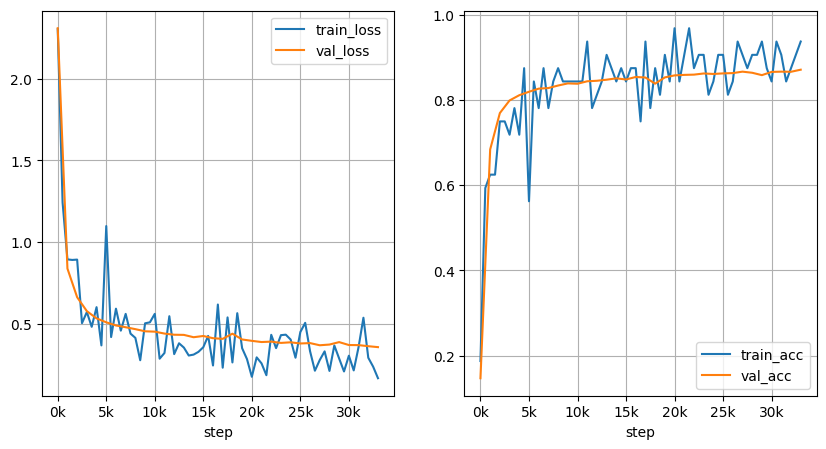

In [44]:
# 画学习曲线，记录的内容包括损失(loss)和准确率(accuracy)
# 需要注意的是，损失值可能不一定在0到1之间，因此要小心处理
def plot_learning_curves(record_dict, sample_step=500):
    # 通过从记录字典中提取训练和验证集的损失和准确率，构建DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step] 
    # 通过“step”设置索引，ilox[::sample_step]是按指定步长进行抽样
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    # 同样通过“step”设置索引，保留验证集数据

    # 输出DataFrame的前几行数据（用于调试）
    print(train_df.head())  
    print(val_df.head())  
    
    # 绘图
    fig_num = len(train_df.columns)  # 计算需要的子图数量，列数决定了有几个指标（如损失和准确率）
    # 创建多个子图，figsize设置为宽度为5倍的子图数量，高度固定为5，便于展示
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))  
    # 通过enumerate(train_df.columns)遍历每一列，列名称通常是“loss”和“accuracy”这些指标
    for idx, item in enumerate(train_df.columns):    
        # idx是子图的索引，item是当前指标的名称（如“loss”或“accuracy”）
        # 绘制训练集和验证集的学习曲线
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")  # 绘制训练集的曲线，横坐标为步数，纵坐标为该指标的值
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")  # 绘制验证集的曲线
        axs[idx].grid()  # 显示网格线，便于观察数据的变化
        axs[idx].legend()  # 显示图例，帮助区分不同的曲线（训练集和验证集）
        
        # 设置x轴的刻度，每隔5000步标出一个点
        x_data = range(0, train_df.index[-1], 5000)  # 获取步数范围，从0到训练集的最后一个step，每隔5000步标出一个点
        axs[idx].set_xticks(x_data)  # 设置x轴刻度为x_data
        # 将x轴的刻度转换为“步数k”的格式，如“5000”变成“5k”
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", x_data))  
        axs[idx].set_xlabel("step")  # 设置x轴标签为“step”

    # 展示图形
    plt.show()

# 调用函数，传入记录的字典，并设定每500步抽样一次数据
plot_learning_curves(record, sample_step=500)  # 横坐标是训练步数（steps）


# 评估

In [45]:
model = NeuralNetwork() #上线时加载模型
model = model.to(device)

In [46]:
# dataload for evaluating
#模型保存有两种情况，一种是模型结构和模型参数都保存，一种是只保存模型参数，这里是只保存模型参数，所以需要加上weights_only=True
# load checkpoints
model.load_state_dict(torch.load("checkpoints/best.ckpt", weights_only=True,map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3581
accuracy: 0.8714
